In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

test = pd.read_csv("/home/jason/Desktop/test.csv")
data = pd.read_csv("/home/jason/Desktop/train.csv")
print(data.head())

num_cols = [col for col in data.columns if data[col].dtype in ["int64", "float64"]]
cat_cols = ["Sex", "Name"]

num_cols = [col for col in num_cols if not col in ['PassengerId', 'Survived']]
X = data[num_cols+cat_cols]
y = data['Survived']
X.head()
X.shape
pattern = "\,\ (.*?)\."
A = []

names1 = ['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'the Countess']
names2 = ['Don', 'Rev', 'Capt', 'Jonkheer']
for i in range(891):
    X['Name'][i] = re.search(pattern, X['Name'][i]).group(1)
    A.append(X['Parch'][i] + X['SibSp'][i])

N = []
    
for i in range(891):
    if X['Name'][i] in  names1:
        N.append(0)
    elif X['Name'][i] in  names2:
        N.append(1)
    elif X['Name'][i] in ['Major', 'Col']:
        N.append(2)
    elif X['Name'][i] in ['Mrs'] :
        N.append(3)
    elif X['Name'][i] in ['Miss'] :
        N.append(4)
    elif X['Name'][i] in ['Master'] :
        N.append(5)
    elif X['Name'][i] in ['Mr'] :
        N.append(6)
    elif X['Name'][i] in ['Dr'] :
        N.append(7)
    
colls = ['Parch', 'SibSp', 'Name']    
X = X.drop(colls, axis=1)
X['Fam'] = A
X.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jason/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Pclass,Age,Fare,Sex,Fam
0,3,22.0,7.2500,male,1
1,1,38.0,71.2833,female,1
2,3,26.0,7.9250,female,0
3,1,35.0,53.1000,female,1
4,3,35.0,8.0500,male,0


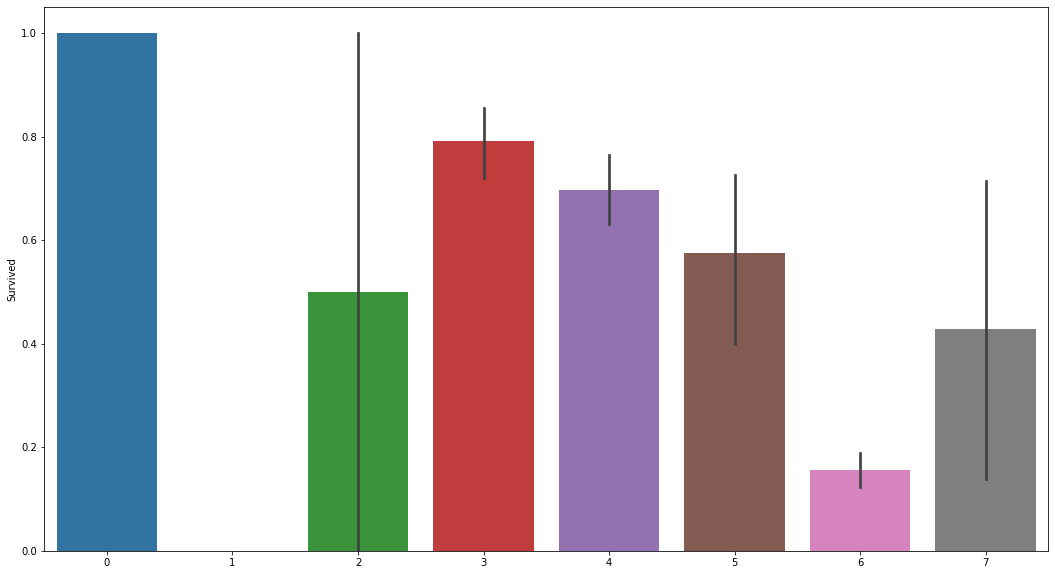

In [2]:
plt.figure(figsize=(18,10))

sns.barplot(x=N, y=y)


In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

i = SimpleImputer()
X_dum = pd.get_dummies(X)
print(X_dum.head())
X_i = pd.DataFrame(i.fit_transform(X_dum))
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

poly.fit(X_i)

X_poly = pd.DataFrame(poly.transform(X_i))
X_poly.shape


   Pclass   Age     Fare  Fam  Sex_female  Sex_male
0       3  22.0   7.2500    1           0         1
1       1  38.0  71.2833    1           1         0
2       3  26.0   7.9250    0           1         0
3       1  35.0  53.1000    1           1         0
4       3  35.0   8.0500    0           0         1


(891, 27)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
clf = KNeighborsClassifier(n_neighbors=3)

svm = LinearSVC(max_iter=3000000)

lg = LogisticRegression()

num_tf = SimpleImputer(strategy="median")
cat_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
pp = ColumnTransformer(
     transformers=[
         ('num', num_tf, num_cols),
         ('cat', cat_tf, cat_cols)
     ]
 )


In [22]:
from sklearn.feature_selection import RFE

select = RFE(
    RandomForestClassifier(n_estimators=140, random_state=42),
    n_features_to_select=12)

select.fit(X_poly, y)
X_1 = pd.DataFrame(select.transform(X_poly))
print(X_1.shape)
X_1['name'] = N
print(X_1.shape)

(891, 12)
(891, 13)


In [30]:
X_1.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y, test_size=0.4, train_size=0.6, random_state=0)

def sc(n, k):
    pl = Pipeline(steps=[
        ('model', XGBClassifier(n_estimators=n, random_state=0, learning_rate=k, n_jobs=-1))
    ])

    pl.fit(X_train, y_train)

    print("\t", pl.score(X_valid, y_valid)*100, n, k)

k = 0.005
for i in range(100, 1500, 50):
    while k < 0.05:
        sc(i, k)
        k += 0.002
    k = 0.005

	 82.91316526610645 100 0.005
	 82.6330532212885 100 0.007
	 83.4733893557423 100 0.009000000000000001
	 83.75350140056022 100 0.011000000000000001
	 83.75350140056022 100 0.013000000000000001
	 84.31372549019608 100 0.015000000000000001
	 84.31372549019608 100 0.017
	 83.75350140056022 100 0.019000000000000003
	 84.03361344537815 100 0.021000000000000005
	 84.03361344537815 100 0.023000000000000007
	 84.593837535014 100 0.02500000000000001
	 84.03361344537815 100 0.02700000000000001
	 84.03361344537815 100 0.029000000000000012
	 85.15406162464986 100 0.031000000000000014
	 84.593837535014 100 0.033000000000000015
	 84.03361344537815 100 0.03500000000000002
	 83.4733893557423 100 0.03700000000000002
	 84.31372549019608 100 0.03900000000000002
	 83.4733893557423 100 0.04100000000000002
	 83.4733893557423 100 0.043000000000000024
	 84.31372549019608 100 0.045000000000000026
	 84.87394957983193 100 0.04700000000000003
	 84.03361344537815 100 0.04900000000000003
	 82.6330532212885 150 0.00

	 82.91316526610645 500 0.02500000000000001
	 81.79271708683473 500 0.02700000000000001
	 81.79271708683473 500 0.029000000000000012
	 82.07282913165265 500 0.031000000000000014
	 82.35294117647058 500 0.033000000000000015
	 82.35294117647058 500 0.03500000000000002
	 82.07282913165265 500 0.03700000000000002
	 82.07282913165265 500 0.03900000000000002
	 81.79271708683473 500 0.04100000000000002
	 81.5126050420168 500 0.043000000000000024
	 81.79271708683473 500 0.045000000000000026
	 81.23249299719888 500 0.04700000000000003
	 80.95238095238095 500 0.04900000000000003
	 84.03361344537815 550 0.005
	 83.4733893557423 550 0.007
	 82.91316526610645 550 0.009000000000000001
	 82.6330532212885 550 0.011000000000000001
	 82.07282913165265 550 0.013000000000000001
	 81.79271708683473 550 0.015000000000000001
	 82.35294117647058 550 0.017
	 82.35294117647058 550 0.019000000000000003
	 81.5126050420168 550 0.021000000000000005
	 82.07282913165265 550 0.023000000000000007
	 82.6330532212885 550

	 81.5126050420168 900 0.043000000000000024
	 82.07282913165265 900 0.045000000000000026
	 81.79271708683473 900 0.04700000000000003
	 81.79271708683473 900 0.04900000000000003
	 83.4733893557423 950 0.005
	 82.35294117647058 950 0.007
	 82.07282913165265 950 0.009000000000000001
	 81.23249299719888 950 0.011000000000000001
	 82.07282913165265 950 0.013000000000000001
	 82.07282913165265 950 0.015000000000000001
	 82.35294117647058 950 0.017
	 82.35294117647058 950 0.019000000000000003
	 82.35294117647058 950 0.021000000000000005
	 82.07282913165265 950 0.023000000000000007
	 81.79271708683473 950 0.02500000000000001
	 82.07282913165265 950 0.02700000000000001
	 81.5126050420168 950 0.029000000000000012
	 81.79271708683473 950 0.031000000000000014
	 81.79271708683473 950 0.033000000000000015
	 81.79271708683473 950 0.03500000000000002
	 81.79271708683473 950 0.03700000000000002
	 81.5126050420168 950 0.03900000000000002
	 81.5126050420168 950 0.04100000000000002
	 81.23249299719888 950

	 82.07282913165265 1350 0.009000000000000001
	 82.35294117647058 1350 0.011000000000000001
	 82.07282913165265 1350 0.013000000000000001
	 81.79271708683473 1350 0.015000000000000001
	 82.35294117647058 1350 0.017
	 82.07282913165265 1350 0.019000000000000003
	 81.79271708683473 1350 0.021000000000000005
	 81.79271708683473 1350 0.023000000000000007
	 81.79271708683473 1350 0.02500000000000001
	 82.07282913165265 1350 0.02700000000000001
	 82.07282913165265 1350 0.029000000000000012
	 82.07282913165265 1350 0.031000000000000014
	 81.79271708683473 1350 0.033000000000000015
	 81.79271708683473 1350 0.03500000000000002
	 81.79271708683473 1350 0.03700000000000002
	 81.79271708683473 1350 0.03900000000000002
	 82.35294117647058 1350 0.04100000000000002
	 81.79271708683473 1350 0.043000000000000024
	 82.6330532212885 1350 0.045000000000000026
	 82.07282913165265 1350 0.04700000000000003
	 81.5126050420168 1350 0.04900000000000003
	 82.07282913165265 1400 0.005
	 82.6330532212885 1400 0.00

In [7]:
X_test=test[num_cols+cat_cols].copy()

A = []
print(X_test['Name'])
pattern = "\,\ (.*?)\."


for i in range(418):
    X_test['Name'][i] = re.search(pattern, X_test['Name'][i]).group(1)
    A.append(X_test['Parch'][i] + X_test['SibSp'][i])

N = []
    
for i in range(418):
    if X_test['Name'][i] in  names1:
        N.append(0)
    elif X_test['Name'][i] in  names2:
        N.append(1)
    elif X_test['Name'][i] in ['Major', 'Col']:
        N.append(2)
    elif X_test['Name'][i] in ['Mrs'] :
        N.append(3)
    elif X_test['Name'][i] in ['Miss'] :
        N.append(4)
    elif X_test['Name'][i] in ['Master'] :
        N.append(5)
    elif X_test['Name'][i] in ['Mr'] :
        N.append(6)
    else:
        N.append(7)
    
colls = ['Parch', 'SibSp', 'Name']    
X_test = X_test.drop(colls, axis=1)
X_test['Fam'] = A

print(X_test.head())
print(len(N))


0                                  Kelly, Mr. James
1                  Wilkes, Mrs. James (Ellen Needs)
2                         Myles, Mr. Thomas Francis
3                                  Wirz, Mr. Albert
4      Hirvonen, Mrs. Alexander (Helga E Lindqvist)
                           ...                     
413                              Spector, Mr. Woolf
414                    Oliva y Ocana, Dona. Fermina
415                    Saether, Mr. Simon Sivertsen
416                             Ware, Mr. Frederick
417                        Peter, Master. Michael J
Name: Name, Length: 418, dtype: object
   Pclass   Age     Fare     Sex  Fam
0       3  34.5   7.8292    male    0
1       3  47.0   7.0000  female    1
2       2  62.0   9.6875    male    0
3       3  27.0   8.6625    male    0
4       3  22.0  12.2875  female    2
418


/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
X_dum = pd.get_dummies(X_test)
print(X_dum.head())

i = SimpleImputer()
X_i = pd.DataFrame(i.fit_transform(X_dum))

poly.fit(X_i)

X_poly = pd.DataFrame(poly.transform(X_i))
X_poly.shape

X_2 = pd.DataFrame(select.transform(X_poly))
print(X_1.shape)
X_2['name'] = N
print(X_2.shape)

   Pclass   Age     Fare  Fam  Sex_female  Sex_male
0       3  34.5   7.8292    0           0         1
1       3  47.0   7.0000    1           1         0
2       2  62.0   9.6875    0           0         1
3       3  27.0   8.6625    0           0         1
4       3  22.0  12.2875    2           1         0
(891, 13)
(418, 13)


In [9]:
pl = Pipeline(steps=[
        ('model', XGBClassifier(n_estimators=850, random_state=0, learning_rate=0.01, n_jobs=-1))
    ])

pl.fit(X_1, y)

pa = pl.predict(X_2)
output = pd.DataFrame({'PassengerId': test.PassengerId,'Survived': pa})
output.to_csv('submission.csv', index=False)